## 1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Без графиков домашку не принимаю

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
from torch import nn
from torch.autograd import Variable

import torchvision
from torchvision import transforms

from PIL import Image
%matplotlib inline

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)] # Если мы создаем последовательность слоев - то мы задаем их
                                                    # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(self.activations[activation]) # layers.append(nn.LeakyReLU(0.2, inplace=True))
            
            return layers
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)]])

        self.model = nn.Sequential(
            *block(in_feat=latent_dim, out_feat=128, normalize=False), # Звездочка означает unpacking списка
            *block(in_feat=128, out_feat=256, activation='lrelu'),
            *block(in_feat=256, out_feat=512),
            *block(in_feat=512, out_feat=1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        
        return img

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

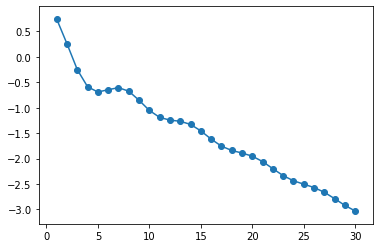

In [4]:
# Генерация графика

def func_y(x):
    return np.sin(x)/x - x/10

x = np.linspace(1, 30, 30)
y = func_y(x)

plt.plot(x, y)
plt.scatter(x, y)
plt.savefig('../data/plot/y_plot.png')

In [5]:
img = Image.open('../data/plot/y_plot.png')

data_transforms = transforms.Compose([
    transforms.ToTensor()
])

imgTensor = data_transforms(img)
imgTensor.shape

torch.Size([4, 288, 432])

In [6]:
n_epochs = 200
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

In [7]:
real_data = torch.utils.data.DataLoader(
    imgTensor,
    batch_size=batch_size,
    shuffle=True,
)

In [8]:
generator = Generator()
discriminator = Discriminator()

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [9]:
d_loss_history = []
g_loss_history = []

In [11]:
red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

for epoch in range(n_epochs):

    batch_size = real_data
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

    valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
    fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

    real_imgs = Variable(imgs.type(torch.FloatTensor))

######################  Тренировка генератора    ##########################

    optimizer_G.zero_grad()

    # генерация шума
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))

    # Генерируем даные Генератором на основе шума
    gen_imgs = generator(z)

    # Подаем сгенерированые данные на Дискриминатор 
    validity = discriminator(gen_imgs)

    # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
    g_loss = adversarial_loss(validity, valid)

    # Делаем шаг обучения нашего Генератора
    g_loss.backward()
    optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

    optimizer_D.zero_grad()

    # Получаем предсказания дискриминатора на основе реальных данных
    real_pred = discriminator(real_imgs)

    # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
    d_real_loss = adversarial_loss(real_pred, valid)

    # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
    fake_pred = discriminator(gen_imgs.detach())

    # расчитываем ошибку предсказанного с фейковыми лейблами
    d_fake_loss = adversarial_loss(fake_pred, fake)

    # И усредняем два лосса в один
    d_loss = (d_real_loss + d_fake_loss) / 2

    d_loss.backward()
    optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############

    batches_done = epoch * len(real_data) + i

    if batches_done % sample_interval == 0:
        with torch.no_grad():
            plt.clf()

            display.clear_output(wait=False)
            sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 


            display.display(plt.gcf())

            d_loss = d_loss.cpu().detach()
            g_loss = g_loss.cpu().detach()


            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()

TypeError: new() received an invalid combination of arguments - got (DataLoader, int), but expected one of:
 * (*, torch.device device)
      didn't match because some of the arguments have invalid types: ([31;1mDataLoader[0m, [31;1mint[0m)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


## 2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.